In [1]:
from dataclasses import dataclass
from typing import Literal, Union, List, Optional
import warnings

import numpy as np
from scipy import optimize as opt

import matplotlib.pyplot as plt
plt.style.use("grayscale")
import plotly.graph_objects as go
from tqdm import tqdm

import gradient
import sets
import drawing as dr

## Вспомогательные функции

### Преобразования между представлениями данных (для работы с библиотекой plotly)

In [2]:
def points_to_xyz_dict(points: np.ndarray):
    points = np.array(points)
    return {"x": points[:, 0], "y": points[:, 1], "z": points[:, 2]}


def point_to_xyz_dict(point: np.ndarray):
    return {"x": point[0], "y": point[1], "z": point[2]}


def plotly_segments(fr: np.array, to: np.array):
    fr = np.array(fr)
    to = np.array(to)

    res = []
    for a, b in zip(fr, to):
        res.append(a)
        res.append(b)

        res.append([None for _ in range(len(a))])

    return np.array(res)

### Задание начальных условий

In [3]:
def shift_on_sphere(vector: np.ndarray, direction: np.ndarray, distance: float):
    result = vector + distance * direction
    return result / np.linalg.norm(result)


def complete_basis(first_vec: np.ndarray, second_vec: Optional[np.ndarray] = None):
    first_vec = np.array(first_vec) / np.linalg.norm(first_vec)

    if second_vec is None:
        second_vec = np.random.rand(len(first_vec))
    second_vec = np.array(second_vec)
    second_vec -= np.dot(second_vec, first_vec) * first_vec
    second_vec = second_vec / np.linalg.norm(second_vec)

    thrid_vec = np.cross(first_vec, second_vec)
    return first_vec, second_vec, thrid_vec


def circle_on_unit_sphere(center: np.ndarray, radius: float = 0.1, N: int = 30):
    center = np.array(center) / np.linalg.norm(center)

    _, u, v = complete_basis(center)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    directions = np.array([np.cos(phi) * u + np.sin(phi) * v for phi in angles])

    return np.array(
        [shift_on_sphere(center, direction, radius) for direction in directions]
    )


def random_shifts_on_sphere(normal: np.ndarray, distance: float = 5e-1, N=4):
    shift_directions = np.random.rand(N, len(normal))
    for i in range(N):
        shift_directions[i] -= normal * np.dot(shift_directions[i], normal)
        shift_directions[i] = shift_directions[i] / np.linalg.norm(shift_directions[i])

    result = np.zeros((N, len(normal)))
    for i in range(N):
        result[i] = normal + shift_directions[i] * distance
        result[i] = result[i] / np.linalg.norm(result[i])

    return result

### Работа с параметрами эксперимента

In [4]:
class KnownValueStopper(gradient.GradientStopper):
    def __init__(self, value: float, precision: float):
        super().__init__()

        self.value = value
        self.precision = precision

    def __call__(self, old_pos, new_pos, old_val, new_val):
        return new_val - self.value < self.precision


@dataclass
class TestParams:
    convex_set: sets.ConvexSet
    normal: np.array
    distance: float
    method: Literal["proj", "cond"]
    step: Union[gradient.ProjGradStep, gradient.CondGradStep]
    precision: float
    max_iter: int = 5000

    def projection(self):
        return self.convex_set(self.normal)

    def projected_point(self):
        return self.projection() + self.distance * self.normal

    def optimized_function(self):
        match self.method:
            case "cond":
                f = lambda x: 0.5 * np.linalg.norm(x - self.projected_point()) ** 2
                grad_f = lambda x: x - self.projected_point()

                return gradient.FunctionWithGradient(f, grad_f)
            case "proj":
                f = lambda p: self.convex_set.s(p) - np.dot(p, self.projected_point())
                grad_f = lambda p: self.convex_set(p) - self.projected_point()

                return gradient.FunctionWithGradient(f, grad_f)

    def solution_point(self):
        match self.method:
            case "cond":
                return self.projection()
            case "proj":
                return self.normal

    def solution_value(self):
        return self.optimized_function()(self.solution_point())

    def init_points(self):
        if self.convex_set.dim == 3:
            normals = circle_on_unit_sphere(self.normal)
        else:
            normals = random_shifts_on_sphere(self.normal)

        match self.method:
            case "cond":
                return np.array([self.convex_set(p) for p in normals])
            case "proj":
                return normals

    def optimizer(self):
        match self.method:
            case "proj":
                return gradient.gradient_projection
            case "cond":
                return gradient.conditional_gradient

    def restriction_set(self):
        match self.method:
            case "cond":
                return self.convex_set
            case "proj":
                return gradient.UnitSphere()

### Запуск эксперимента, работа с результатом

In [5]:
@dataclass
class TestRun:
    params: TestParams
    logger: gradient.BasicLogger

    def has_converged(self):
        return (
            self.logger["val"][-1] - self.params.solution_value()
            < self.params.precision
        )

    def point_errors(self):
        points = self.logger["x"]
        optimal = self.params.solution_point()
        return np.array([np.linalg.norm(point - optimal) for point in points])

    def value_errors(self):
        values = self.logger["val"]
        optimal = self.params.solution_value()
        return np.array(values) - optimal

    def __len__(self):
        return len(self.logger["x"])


def run_test(params: TestParams, init_point: np.array) -> TestRun:
    logger = gradient.BasicLogger()
    params.optimizer()(
        params.optimized_function(),
        params.restriction_set(),
        init_point,
        KnownValueStopper(params.solution_value(), params.precision),
        params.step,
        params.max_iter,
        logger,
    )

    return TestRun(params, logger)


def get_runs(params: TestParams) -> List[TestRun] | None:
    runs = []
    for init in params.init_points():
        run = run_test(params, init)
        if not run.has_converged():
            return None

        runs.append(run)

    return runs

## Задачи с множеством достижимости

Рассматривается операция проецирования на множество $\mathcal{R}_2 + \mathcal{B}_1(0)$, где
$\mathcal{R}_t$ &mdash; множество достижимости вида
$$
    \mathcal{R}_t = \int_0^t e^{As}\, \mathcal{U}\, ds, 
    \quad 
    A = \begin{pmatrix}
        -1 & 1 & 0 \\
        0 & -1 & 1 \\
        0 & 0 & -1
    \end{pmatrix},
    \quad
    \mathcal{U} = \operatorname{co}\{e_3, -e_3\}.
$$

### Сравнение методов проекции градиента и метода условного градиента (рис. 2)

#### Функции для оценки постоянной в формуле линейной сходимости

In [6]:
from typing import Callable


def fit_linear_line(seq: np.ndarray, take_last: Optional[int] = None):
    linear_fun = lambda x, a, b: a * x + b
    yy = np.log(seq)
    xx = np.arange(len(yy))

    if take_last is not None:
        xx = xx[-take_last:]
        yy = yy[-take_last:]

    return opt.curve_fit(linear_fun, xx, yy)[0]


def estimate_linear_convergence_speed(seq: np.ndarray, take_last: Optional[int] = None):
    if len(seq) < 2:
        warnings.warn("Sequence too short to estimate linear convergence")
        return 0
    if seq[-1] == 0:
        warnings.warn("Precise convergence")
        return 0

    return np.exp(fit_linear_line(seq, take_last)[0])


def select_run(params: TestParams, selector: Callable[[np.ndarray], int]):
    runs = get_runs(params)
    if runs is None:
        return None, None

    speeds = np.array(
        [estimate_linear_convergence_speed(run.value_errors()) for run in runs]
    )
    index = selector(speeds)
    return speeds[index], runs[index]

#### Параметры задачи

In [7]:
# Упомянутое в статье семейство нормалей
def normal_family(z):
    return np.array([np.sqrt((1 - z**2) / 2), -np.sqrt((1 - z**2) / 2), z])


normal_sc = normal_family(2 / 7)
normal_no_sc = normal_family(1 / 3)
distance = 2

methods = ["proj", "cond"]
normals = {"sc": normal_sc, "no_sc": normal_no_sc}

# Диапазоны изменения параметров для различных комбинаций метода и задачи
steps = {
    # alpha от 5e-2 до 2e-1, 200 точек
    ("proj", "sc"): (np.linspace(5e-2, 2e-1, 200), gradient.StepConst),
    # alpha от 5e-2 до 1.5, 200 точек
    ("proj", "no_sc"): (np.linspace(5e-2, 1.5, 200), gradient.StepConst),
    # gamma от 5e-2 до 2 - 5e-2, 200 точек
    ("cond", "sc"): (np.linspace(5e-2, 2 - 5e-2, 200), gradient.StepStandard),
    # gamma от 5e-2 до 2 - 5e-2, 200 точек
    ("cond", "no_sc"): (np.linspace(5e-2, 2 - 5e-2, 200), gradient.StepStandard),
}

precision = 1e-4
max_iterations = 1000

eps = 1
R = sets.ExampleAttSet()
R_2 = sets.SetWithBoundArgs(R, (2,))
R_2_eps = R_2 + sets.Ball(np.zeros(3), eps)

#### Запуск экспериментов

In [8]:
speeds = {}

for method in methods:
    for setup, vector in normals.items():
        speeds[method, setup] = []

        step_sizes, step_type = steps[method, setup]

        for step_size in tqdm(step_sizes):
            params = TestParams(
                R_2_eps,
                vector,
                distance,
                method,
                step_type(step_size),
                precision,
                max_iterations,
            )

            convergence_speed, run = select_run(params, np.argmax)
            if convergence_speed is None:
                break

            speeds[method, setup].append(convergence_speed)

 32%|█████████████████████████████████████████████████▎                                                                                                        | 64/200 [00:03<00:06, 21.60it/s]/tmp/ipykernel_9885/2829548734.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  return opt.curve_fit(linear_fun, xx, yy)[0]
 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 154/200 [00:08<00:04, 10.75it/s]/home/kamil/Documents/prog/nauch/bb25-code/gradient.py:115: UserWarning: gradient_projection reached max_iter = 1000
  warnings.warn(f"gradient_projection reached max_iter = {max_iter}")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.46it/s]


 32%|███▏      | 64/200 [00:03<00:06, 22.37it/s]/tmp/ipykernel_8958/2829548734.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  return opt.curve_fit(linear_fun, xx, yy)[0]
 77%|███████▋  | 154/200 [00:08<00:04, 10.73it/s]/home/kamil/Documents/prog/nauch/bb25-code/gradient.py:115: UserWarning: gradient_projection reached max_iter = 1000
  warnings.warn(f"gradient_projection reached max_iter = {max_iter}")
100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


#### Отображение результатов

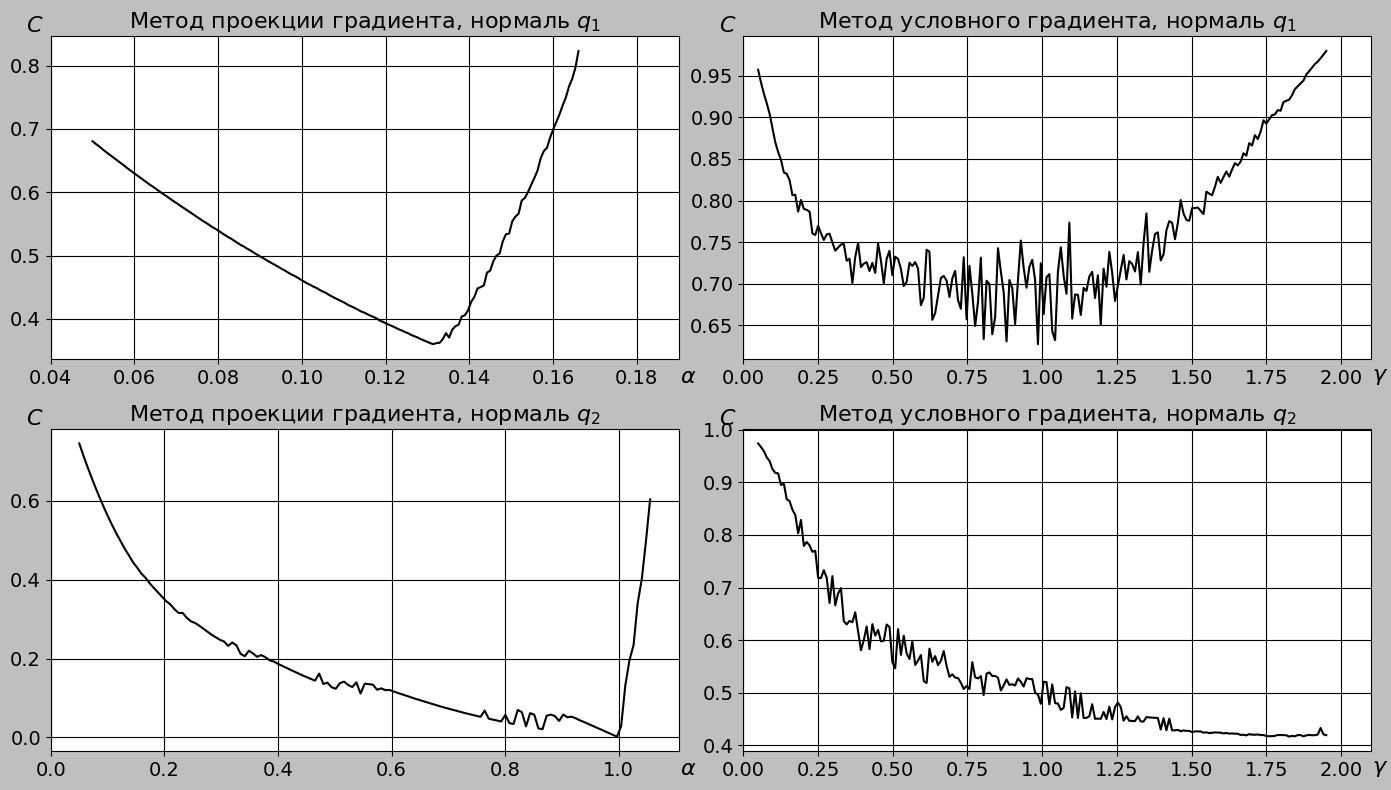

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for ax_row, setup in zip(axs, normals):
    for ax, method in zip(ax_row, methods):
        yy = speeds[method, setup]
        xx = steps[method, setup][0][: len(yy)]

        ax.plot(xx, yy)

text_fontsize = 16
ticklabel_fontsize = 14
for i in [0, 1]:
    for j in [0, 1]:
        ax = axs[i][j]
        ax.tick_params(axis="both", which="major", labelsize=ticklabel_fontsize)

        if j == 1:
            ax.set_xlim(0, 2.1)

        xlabel = "$\\alpha$" if j == 0 else "$\\gamma$"
        ax.set_xlabel(xlabel, fontsize=text_fontsize)
        ax.xaxis.set_label_coords(1.015, -0.025)

        ax.set_ylabel("$C$", rotation=0, fontsize=text_fontsize)
        ax.yaxis.set_label_coords(-0.025, 1.0)

        if j == 0:
            ax.set_title(
                f"Метод проекции градиента, нормаль $q_{i+1}$", fontsize=text_fontsize
            )
        else:
            ax.set_title(
                f"Метод условного градиента, нормаль $q_{i+1}$", fontsize=text_fontsize
            )

        ax.grid()

axs[0][0].set_xlim(0.04, 0.19)
fig.subplots_adjust(right=1)
fig.tight_layout()

In [10]:
fig.savefig("images/attset_speed.png", bbox_inches="tight")

### Сходимость метода проекции градиента при отсутствии условия $sc$ (рис. 3)

#### Параметры задачи, запуск эксперимента

In [11]:
convex_set = R_2_eps
solution_normal = normal_no_sc
distance = 2
step = gradient.StepConst(1e-1)
precision = 1e-5

params = TestParams(convex_set, solution_normal, distance, "proj", step, precision)
init_point = np.array([0.4, 0.3, -0.1])
init_point = init_point / np.linalg.norm(init_point)

run = run_test(params, init_point)

#### Отображение результата

In [12]:
fig = go.Figure()

normals = np.array(run.logger["x"])
supports = np.array([R_2_eps(p) for p in normals])

dr.draw_set_3d(R_2_eps, fig, "lattice", color="lightblue")
fig.add_scatter3d(**points_to_xyz_dict(supports), line=dict(width=7))

normals_ends = supports + normals
fig.add_scatter3d(
    **points_to_xyz_dict(plotly_segments(supports, normals_ends)),
    line=dict(width=5, color="black"),
    marker=dict(size=3)
)
fig.add_scatter3d(
    **points_to_xyz_dict([params.projected_point(), params.projection()]),
    mode="lines+markers+text",
    text=["проецируемая точка", ""],
    line=dict(width=7, color="green"),
    textfont=dict(
        size=20,
    )
)


ax_limits = np.array([[-2, 2.5], [-2.5, 2], [-2, 2]])
halflengths = np.diff(ax_limits).flatten() / 2
ax_center = np.mean(ax_limits, axis=1)

fig.update_layout(
    uniformtext_minsize=40,
    scene=dict(
        xaxis=dict(
            range=ax_limits[0],
            visible=False,
            showticklabels=False,
        ),
        yaxis=dict(
            range=ax_limits[1],
            visible=False,
            showticklabels=False,
        ),
        zaxis=dict(
            range=ax_limits[2],
            visible=False,
            showticklabels=False,
        ),
        aspectratio=dict(x=1, y=1, z=1),
    ),
)

camera_center = (R_2(normal_no_sc) - ax_center) / halflengths * 0.5 + np.array(
    [0, 0, 0.5]
)

eye_direction = np.array([1, 0.2, -0.4])
eye_direction = eye_direction / np.linalg.norm(eye_direction)
eye_distance = 1
camera_eye = eye_distance * eye_direction

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=point_to_xyz_dict(camera_center),
    eye=point_to_xyz_dict(camera_eye),
)
fig.update_layout(scene_camera=camera, showlegend=False)

fig.write_html("html/att_set_crit_proj.html")

Output()

In [13]:
fig.write_image("images/proj_grad_att_crit.png", width=1600, height=1000)

### Сходимость метода условного градиента при отсутствии условия $sc$ (рис. 4)

#### Параметры эксперимента

In [14]:
gammas = [0.4, 0.8, 1.2, 1.8]

convex_set = R_2_eps
solution_normal = normal_no_sc
distance = 2
precision = 1e-8
max_iterations = 2000

#### Запуск экспериментов

In [15]:
runs = []
for gamma in gammas:
    params = TestParams(
        convex_set,
        solution_normal,
        distance,
        "cond",
        gradient.StepStandard(gamma),
        precision,
        max_iterations,
    )
    _, run = select_run(params, np.argmax)

    runs.append(run)

#### Отображение результатов

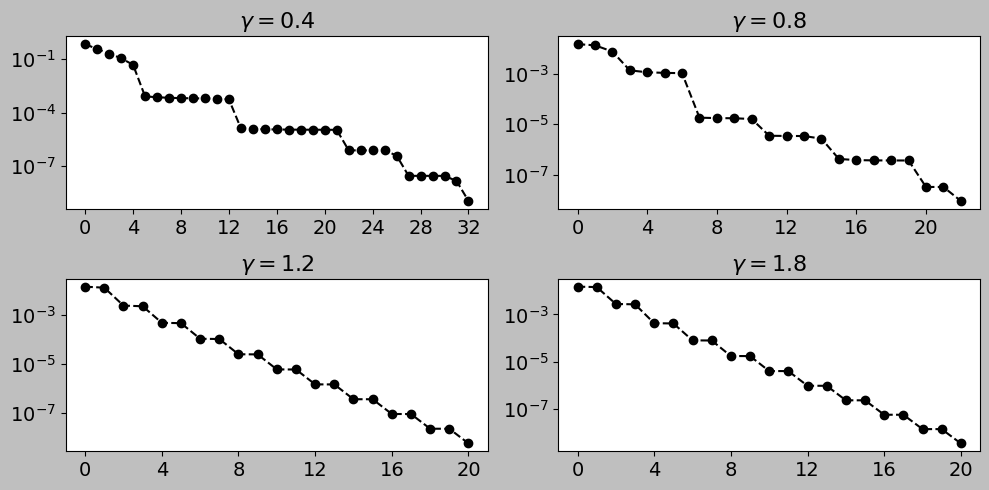

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=2, ncols=2)

text_fontsize = 16
ticklabel_fontsize = 14

for i, ax in enumerate(np.array(ax).flatten()):
    ax.tick_params(axis="both", which="major", labelsize=ticklabel_fontsize)

    run = runs[i]

    yy = run.value_errors()
    xx = np.arange(len(yy))

    ax.plot(xx, yy, "--o", label=f"gamma = {run.params.step.gamma}")
    ax.set_xticks(xx[::4])

    ax.set_yscale("log")
    ax.set_title(f"$\\gamma = {run.params.step.gamma}$", fontsize=text_fontsize)

fig.tight_layout()

In [17]:
fig.savefig("images/attset_cond_grad_jumps.png")

## Задачи с шаром в $\sigma$-норме

Рассматривается задача проецирования на шар в $\sigma$-норме:
$$
    \mathcal{B}_1^\sigma(0) = \{x\in\mathbb{R}^n \mid \|x\|_\sigma \leq 1\},
    \quad
    \|x\|_\sigma = \left(\sum_{i=1}^n x_i^\sigma\right)^{1/\sigma}
$$

### Расходимость метода проекции градиента (рис. 5, $\sigma$=10)

#### Функция $\varphi$ (зависимость $y$-координаты следующего шага от $y$-координаты текущего)

In [18]:
def projection_gradient_next_y(y: float, ball: sets.PNormBall, alpha: float = 1e-1):
    normal = np.array([np.sqrt(1 - y**2), y])
    grad = ball(normal)

    next_normal = normal - alpha * grad
    next_normal = next_normal / np.linalg.norm(next_normal)
    return next_normal[1]

#### Параметры экспериментов

In [19]:
sigma = 10
convex_set = sets.PNormBall(np.array([-2, 0]), 1, sigma)
solution_normal = np.array([1, 0])
distance = 1
precision = 1e-8
max_iterations = 50

init_normal = np.array([1, 0.1])

step_sizes = np.array([5e-3, 1e-2, 2e-2])

#### Запуск экспериментов

In [20]:
runs = []
for alpha in step_sizes:
    params = TestParams(
        convex_set,
        solution_normal,
        distance,
        "proj",
        gradient.StepConst(alpha),
        precision,
        max_iterations,
    )

    runs.append(run_test(params, init_normal))

/home/kamil/Documents/prog/nauch/bb25-code/gradient.py:115: UserWarning:

gradient_projection reached max_iter = 50



#### Отображение результатов

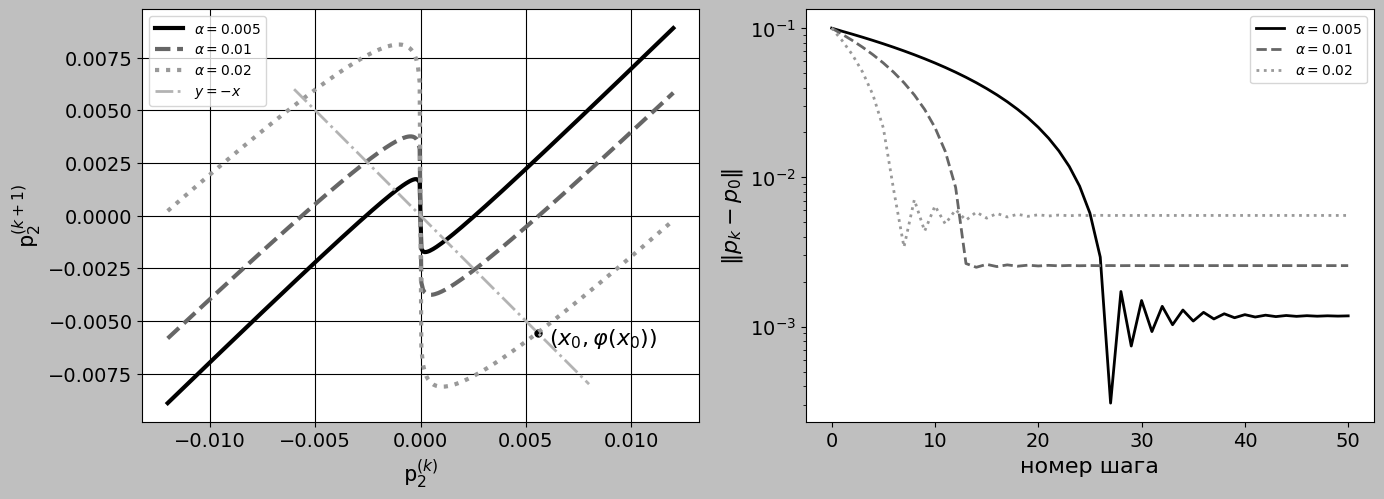

In [21]:
fig, axs = plt.subplots(figsize=(14, 5), ncols=2)

axs[0].set_aspect("equal")
axs[1].set_yscale("log")


xx = np.linspace(-12e-3, 12e-3, 300)
for run, line in zip(runs, ["-", "--", ":"]):
    alpha = run.params.step.alpha

    yy = np.array([projection_gradient_next_y(y, convex_set, alpha) for y in xx])

    # axs[0].set_ylim(min(yy) * 1.5, max(yy) * 1.5)

    axs[0].plot(xx, yy, line, label=f"$\\alpha = {alpha}$", linewidth=3)
    axs[1].plot(run.point_errors(), line, label=f"$\\alpha = {alpha}$", linewidth=2)

line_xx = np.linspace(-0.006, 0.008)
axs[0].plot(line_xx, -line_xx, "-.", label="$y=-x$", linewidth=2)


x0 = runs[-1].logger["x"][-1][1]
# axs[0].vlines([x0], *axs[0].get_ylim())

text_fontsize = 16

axs[0].set_xlabel("${\\tt p}_2^{(k)}$", fontsize=text_fontsize)
axs[0].set_ylabel("${\\tt p}_2^{(k+1)}$", fontsize=text_fontsize)

axs[1].set_xlabel("номер шага", fontsize=text_fontsize)
axs[1].set_ylabel("$\\|p_k - p_0\\|$", fontsize=text_fontsize)

axs[0].scatter([x0], [-x0], s=25)
axs[0].text(x0 * 1.1, -x0 * 1.1, "$(x_0, \\varphi(x_0))$", fontsize=text_fontsize)

ticklabel_fontsize = 14
for ax in axs:
    ax.tick_params(axis="both", which="major", labelsize=ticklabel_fontsize)

# axs[0].set_xticks([-5e-3, 0, 5e-3])

axs[0].grid()
axs[0].legend()
axs[1].legend()


fig.tight_layout()

In [22]:
fig.savefig("images/ball_cycles.png", bbox_inches="tight")

### Сходимость метода условного градиента (рис. 6)

#### Функции для нахождения показателя в оценке скорости сходимости

In [23]:
def fit_sublinear_line(seq: np.ndarray, take_last: Optional[int] = None):
    yy = np.log(seq)
    xx = np.log(np.arange(len(seq)) + 1)

    if take_last is not None:
        xx = xx[-take_last:]
        yy = yy[-take_last:]

    curve = lambda x, a, b: a * x + b

    return opt.curve_fit(curve, xx, yy)[0]


def estimate_sublinear_degree(run: TestRun, last: Optional[int] = None):
    return fit_sublinear_line(run.value_errors(), last)[0]

#### Параметры экспериментов

In [24]:
# для левого рисунка
norms = np.arange(3, 8)
# для правого рисунка
norms_near_two = np.linspace(2.1, 3.1, 5)

convex_sets = [sets.PNormBall(np.zeros(3), 1, sigma) for sigma in norms]
convex_sets_near_two = [
    sets.PNormBall(np.zeros(3), 1, sigma) for sigma in norms_near_two
]

solution_normal = np.array([1, 0, 0])
distance = 1
precision = 1e-8
max_iterations = 2000

np.random.seed(42)
init_normal = random_shifts_on_sphere(solution_normal, 0.1, 1)[0]

init_points = [convex_set(init_normal) for convex_set in convex_sets]
init_points_near_two = [convex_set(init_normal) for convex_set in convex_sets_near_two]

#### Запуск экспериментов

In [25]:
runs = []
for convex_set, init_point in zip(convex_sets, init_points):
    runs.append(
        run_test(
            TestParams(
                convex_set,
                solution_normal,
                distance,
                "cond",
                gradient.StepStandard(1),
                precision,
                max_iterations,
            ),
            init_point,
        )
    )

estimated_degrees = np.array(
    [estimate_sublinear_degree(run, 3 * len(run) // 4) for run in runs]
)

runs_near_two = []
for convex_set, init_point in zip(convex_sets_near_two, init_points_near_two):
    runs_near_two.append(
        run_test(
            TestParams(
                convex_set,
                solution_normal,
                distance,
                "cond",
                gradient.StepStandard(1),
                precision,
                max_iterations,
            ),
            init_point,
        )
    )

/home/kamil/Documents/prog/nauch/bb25-code/gradient.py:181: UserWarning:

conditional_gradient reached max_iter = 2000



#### Отображение результатов

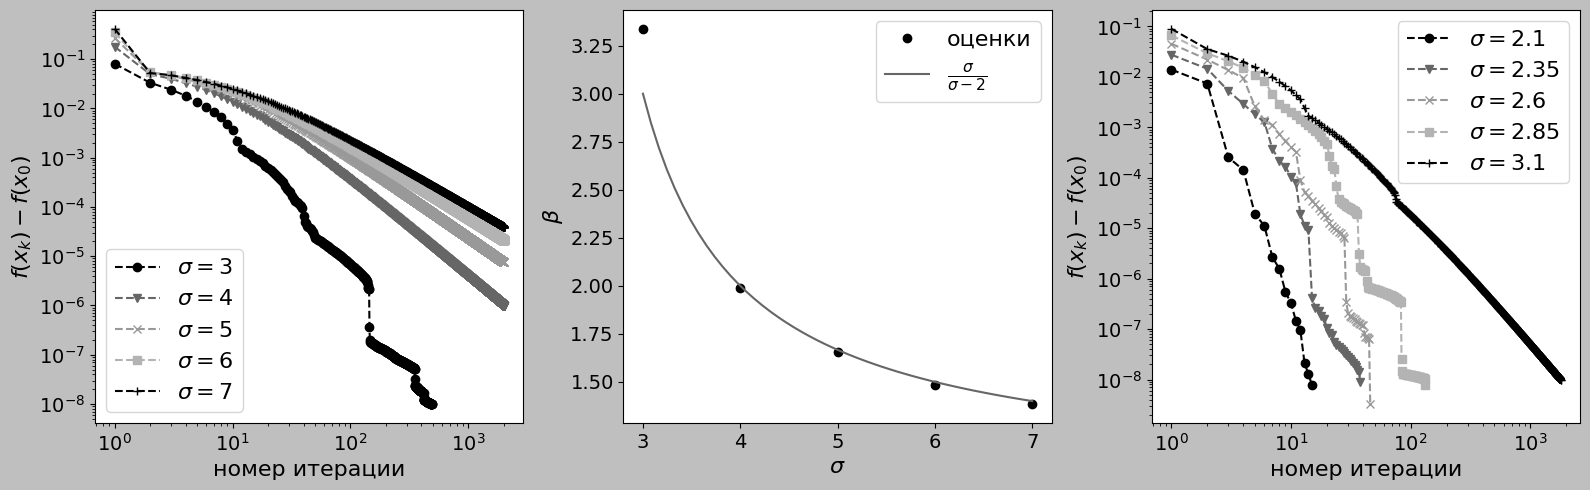

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 5))

text_fontsize = 16
ticklabel_fontsize = 14
plt.rc("legend", fontsize=text_fontsize)

for ax in axs:
    ax.tick_params(axis="both", which="major", labelsize=ticklabel_fontsize)

markers = ["o", "v", "x", "s", "+"]

axs[0].set_xscale("log")
axs[0].set_yscale("log")

for run, marker in zip(runs, markers):
    yy = run.value_errors()
    xx = np.arange(len(yy)) + 1

    axs[0].plot(
        xx, yy, f"--{marker}", label=f"$\\sigma = {run.params.convex_set.norm}$"
    )

axs[0].legend()
axs[0].set_xlabel("номер итерации", fontsize=text_fontsize)
axs[0].set_ylabel("$f(x_k) - f(x_0)$", fontsize=text_fontsize)


xx = np.linspace(min(norms), max(norms))
axs[1].plot(norms, -estimated_degrees, "o", label="оценки")
axs[1].plot(xx, xx / (xx - 2), label="$\\frac{\\sigma}{\\sigma-2}$")

axs[1].set_ylabel("$\\beta$", fontsize=text_fontsize)
axs[1].set_xlabel("$\\sigma$", fontsize=text_fontsize)

axs[1].legend()


axs[2].set_xscale("log")
axs[2].set_yscale("log")
for run, marker in zip(runs_near_two, markers):
    yy = run.value_errors()
    xx = np.arange(len(yy)) + 1

    axs[2].plot(
        xx, yy, f"--{marker}", label=f"$\\sigma = {run.params.convex_set.norm}$"
    )

axs[2].set_xlabel("номер итерации", fontsize=text_fontsize)
axs[2].set_ylabel("$f(x_k) - f(x_0)$", fontsize=text_fontsize)
axs[2].legend()

fig.tight_layout()

In [27]:
fig.savefig("images/ball_cond_speed.png")